# Quick Graph Dataset Analysis
This notebook scans the graph files under `submodules/graph-token/graphs`, computes basic statistics (nodes, edges, degree stats, connected components), and shows simple visualizations for a quick sanity-check. It's intentionally conservative about how many files it reads so it stays fast.

In [20]:
# Imports
import os

from pathlib import Path
import glob
import networkx as nx
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

In [21]:
# Configure the graphs directory (absolute path ensures notebook runs from any cwd)
BASE = Path('/data/young/capstone/graph-learning-benchmarks/submodules/graph-token/graphs')
assert BASE.exists(), f'Graphs base dir not found: {BASE}'
# list top-level dataset directories (e.g., 'ba', 'er', 'path', ...)
datasets = sorted([p.name for p in BASE.iterdir() if p.is_dir()])
print('Found datasets:', datasets)

Found datasets: ['ba', 'complete', 'er', 'path', 'sbm', 'sfn', 'star']


In [22]:
def analyze_graph(path: Path) -> dict:
    """Read a graphml file and return basic stats.
    Returns a dict with: path, nodes, edges, avg_deg, max_deg, min_deg, deg_median, deg_std, components, largest_cc, avg_cc_size, directed, clustering
    """
    try:
        G = nx.read_graphml(path)
    except Exception as e:
        return {'error': str(e), 'path': str(path)}
    n = G.number_of_nodes()
    m = G.number_of_edges()
    directed = nx.is_directed(G)
    if n > 0:
        degrees = [d for _, d in G.degree()]
        avg_deg = float(np.mean(degrees))
        max_deg = int(np.max(degrees))
        min_deg = int(np.min(degrees))
        deg_median = float(np.median(degrees))
        deg_std = float(np.std(degrees, ddof=0))
    else:
        degrees = []
        avg_deg = max_deg = min_deg = deg_median = deg_std = 0
    # connected components: use weakly connected for directed graphs and compute sizes
    try:
        if directed:
            comp_iter = nx.weakly_connected_components(G)
        else:
            comp_iter = nx.connected_components(G)
        comp_sizes = [len(c) for c in comp_iter]
        comps = len(comp_sizes)
        largest_cc = int(max(comp_sizes)) if comp_sizes else 0
        avg_cc_size = float(np.mean(comp_sizes)) if comp_sizes else 0.0
    except Exception:
        comps = None
        largest_cc = None
        avg_cc_size = None
    # clustering (undirected) - may raise for very large graphs, handle safely
    try:
        if directed:
            clu = nx.average_clustering(G.to_undirected())
        else:
            clu = nx.average_clustering(G)
    except Exception:
        clu = None
    return dict(path=str(path), nodes=int(n), edges=int(m), avg_deg=avg_deg, max_deg=max_deg, min_deg=min_deg, deg_median=deg_median, deg_std=deg_std, components=comps, largest_cc=largest_cc, avg_cc_size=avg_cc_size, directed=directed, clustering=clu)

In [23]:
# Scan dataset folders and analyze a limited number of graphs for a quick summary
results = []
limit_per_split = 100  # max files to read per dataset split to keep analysis quick
for ds in datasets:
    ds_dir = BASE / ds
    # expected splits like train/valid/test under each dataset
    for split in sorted([p for p in ds_dir.iterdir() if p.is_dir()]):
        files = sorted(list(split.glob('*.graphml')))
        if not files:
            continue
        to_take = files[:limit_per_split]
        for p in to_take:
            res = analyze_graph(p)
            # attach metadata
            if 'error' not in res:
                res['dataset'] = ds
                res['split'] = split.name
            else:
                res['dataset'] = ds
                res['split'] = split.name
            results.append(res)
print(f'Analyzed {len(results)} graph files (up to {limit_per_split} per split).')

Analyzed 2100 graph files (up to 100 per split).


In [24]:
# Build DataFrame and show summary
df = pd.DataFrame(results)
# separate error rows if any
if 'error' in df.columns:
    error_df = df[df['error'].notnull()]
else:
    error_df = pd.DataFrame([])
# Convert numeric columns
num_cols = ['nodes','edges','avg_deg','max_deg','min_deg','components','clustering','deg_median','deg_std','largest_cc','avg_cc_size']
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
# Build a safe boolean mask for rows without errors
if 'error' in df.columns:
    good_mask = df['path'].notnull() & df['error'].isna()
else:
    good_mask = df['path'].notnull()
# Derived metrics: density (undirected formula), edges per node
df.loc[:, 'density'] = df.apply(lambda r: (r['edges'] / (r['nodes'] * (r['nodes'] - 1))) if pd.notnull(r['nodes']) and r['nodes'] > 1 else 0.0, axis=1)
df.loc[:, 'edges_per_node'] = df.apply(lambda r: (r['edges'] / r['nodes']) if pd.notnull(r['nodes']) and r['nodes'] > 0 else 0.0, axis=1)
# Summary by dataset (safe: use only good rows)
summary = df[good_mask].groupby('dataset').agg({
    'nodes':['count','mean','median','min','max'],
    'edges':['mean','median'],
    'avg_deg':['mean','median'],
    'deg_std':['mean'],
    'density':['mean'],
})
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index()
display(summary)
if not error_df.empty:
    print('Some files failed to read (showing up to 10):')
    display(error_df.head(10))

,dataset,nodes_count,nodes_mean,nodes_median,nodes_min,nodes_max,edges_mean,edges_median,avg_deg_mean,avg_deg_median,deg_std_mean,density_mean
0,ba,300,12.080000,12.0,5,19,29.376667,22.0,4.350560,3.750000,2.432691,0.201240
1,complete,300,12.073333,12.0,5,19,75.633333,66.0,11.073333,11.000000,0.000000,0.500000
2,er,300,12.086667,12.0,5,19,37.416667,23.5,5.413207,4.461538,1.125368,0.243620
3,path,300,12.073333,12.0,5,19,11.073333,11.0,1.807667,1.833333,0.381498,0.096167
4,sbm,300,11.926667,12.0,5,19,36.736667,30.0,5.375482,5.000000,1.670846,0.245675
5,sfn,300,12.073333,12.0,5,19,15.360000,15.0,2.499552,2.500000,2.290154,0.132610
6,star,300,12.073333,12.0,5,19,11.073333,11.0,1.807667,1.833333,2.686480,0.096167


In [25]:
# Simple plots using matplotlib (no seaborn)
plot_df = df[df['path'].notnull() & df.get('error', pd.Series()).isna()]
if plot_df.empty:
    print('No graph data available to plot.')
else:
    # Boxplot of nodes by dataset
    datasets = sorted(plot_df['dataset'].unique())
    groups = [plot_df.loc[plot_df['dataset'] == d, 'nodes'].dropna().values for d in datasets]
    plt.figure(figsize=(12,6))
    plt.boxplot(groups, labels=datasets, showfliers=False, patch_artist=True)
    plt.xticks(rotation=45)
    plt.ylabel('Nodes')
    plt.title('Nodes distribution by dataset (sample)')
    plt.tight_layout()
    plt.show()
    # Scatter: edges vs nodes (log scales for readability)
    plt.figure(figsize=(10,6))
    cmap = plt.get_cmap('tab20')
    color_map = {d: cmap(i % 20) for i,d in enumerate(datasets)}
    for d in datasets:
        sub = plot_df[plot_df['dataset'] == d]
        plt.scatter(sub['nodes'], sub['edges'], alpha=0.6, label=d, color=color_map[d], s=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Nodes (log)')
    plt.ylabel('Edges (log)')
    plt.title('Edges vs Nodes (sample, log-log)')
    plt.legend(ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    # Histograms: avg_deg and max_deg
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(plot_df['avg_deg'].dropna(), bins=50, color='#4c72b0')
    plt.title('Average degree (sample)')
    plt.xlabel('avg_deg')
    plt.subplot(1,2,2)
    # log-binned histogram for max degree
    max_deg = plot_df['max_deg'].dropna()
    if not max_deg.empty:
        bins = np.unique(np.logspace(0, math.log10(max(1, max_deg.max())), num=40).astype(int))
        plt.hist(max_deg, bins=bins, color='#dd8452')
        plt.xscale('log')
    plt.title('Max degree (sample)')
    plt.xlabel('max_deg (log scale)')
    plt.tight_layout()
    plt.show()

No graph data available to plot.


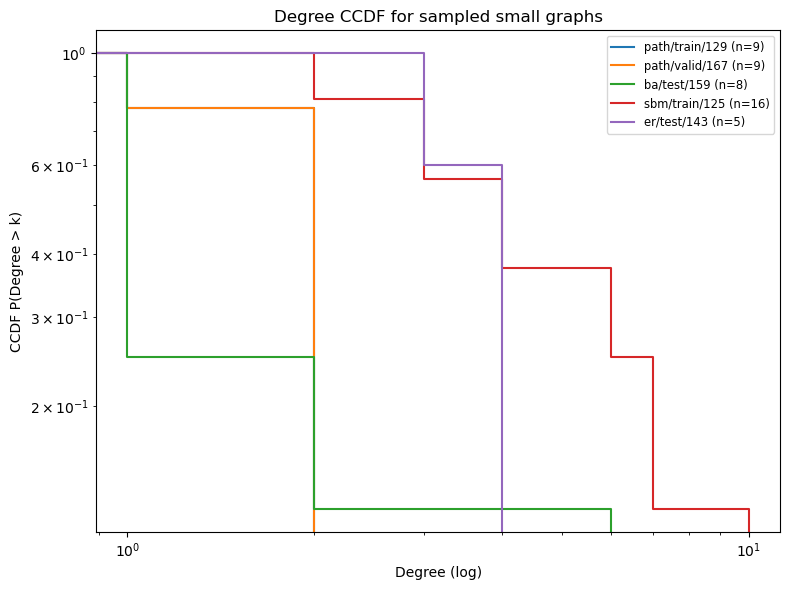

Saved viz/degree_ccdf_sample.png


In [26]:
# Degree CCDF plots for a few small sampled graphs (log-log)
from pathlib import Path
viz_out = Path('viz')
viz_out.mkdir(exist_ok=True)
good = df[good_mask].copy()
if 'nodes' in good.columns:
    candidates = good[good['nodes'] <= 200]
else:
    candidates = good
n_take = min(5, len(candidates))
if n_take == 0:
    print('No small graphs available for CCDF sampling. Increase threshold or ensure nodes were computed.')
else:
    sample_small = candidates.sample(n=n_take, random_state=42) if len(candidates) > n_take else candidates
    plt.figure(figsize=(8,6))
    for _, row in sample_small.iterrows():
        p = Path(row['path'])
        try:
            G = nx.read_graphml(p)
        except Exception as e:
            print('Failed to read', p, e)
            continue
        degs = np.array([d for _, d in G.degree()])
        if degs.size == 0:
            continue
        vals, edges = np.histogram(degs, bins=range(0, int(degs.max())+2))
        cdf = np.cumsum(vals) / vals.sum()
        ccdf = 1.0 - cdf
        plt.step(edges[:-1]+0.0, ccdf, where='post', label=f"{row.get('dataset','?')}/{row.get('split','')}/{p.stem} (n={row.get('nodes','?')})")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log)')
    plt.ylabel('CCDF P(Degree > k)')
    plt.title('Degree CCDF for sampled small graphs')
    plt.legend(fontsize='small')
    plt.tight_layout()
    out = viz_out / 'degree_ccdf_sample.png'
    plt.savefig(out, dpi=150)
    plt.show()
    print('Saved', out)

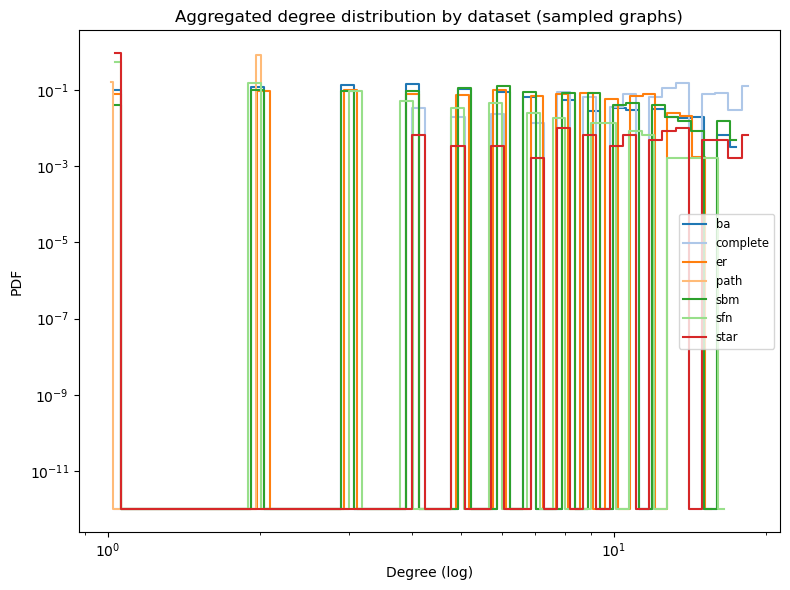

Saved viz/degree_dist_by_dataset.png


/tmp/ipykernel_987034/184113129.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups_filtered, labels=labels, showfliers=False, patch_artist=True)


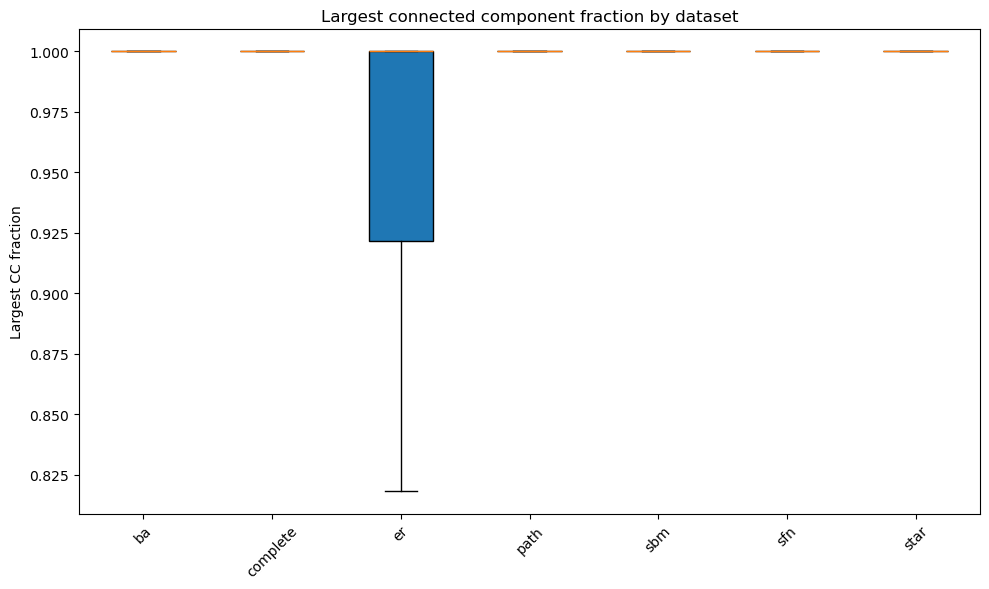

Saved viz/largest_cc_fraction.png


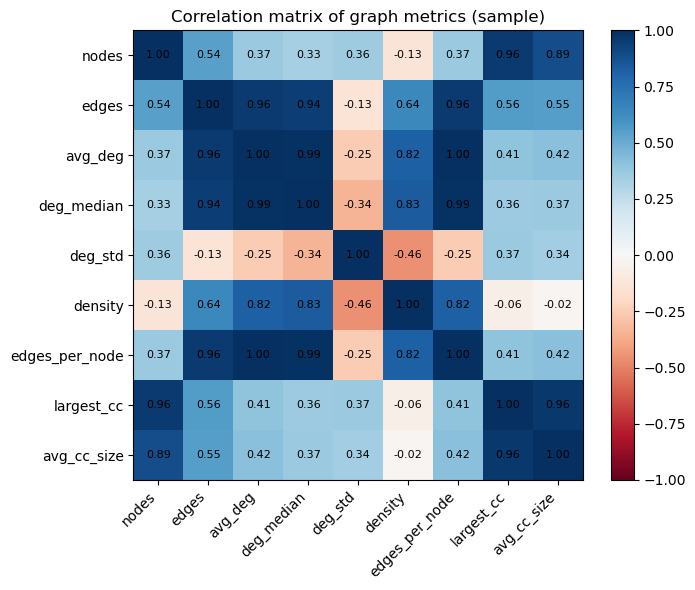

Saved viz/metric_correlation.png


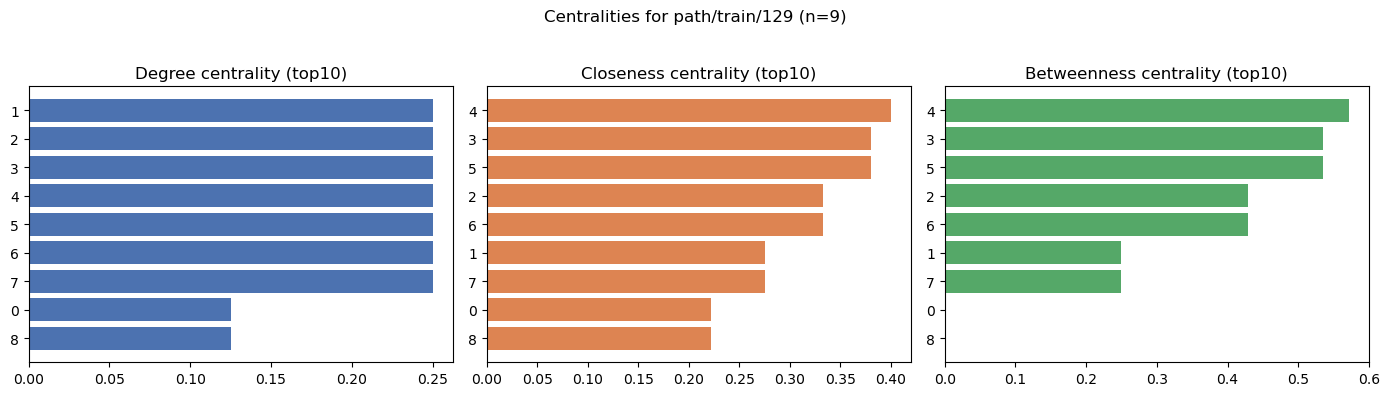

Saved viz/centrality_129.png


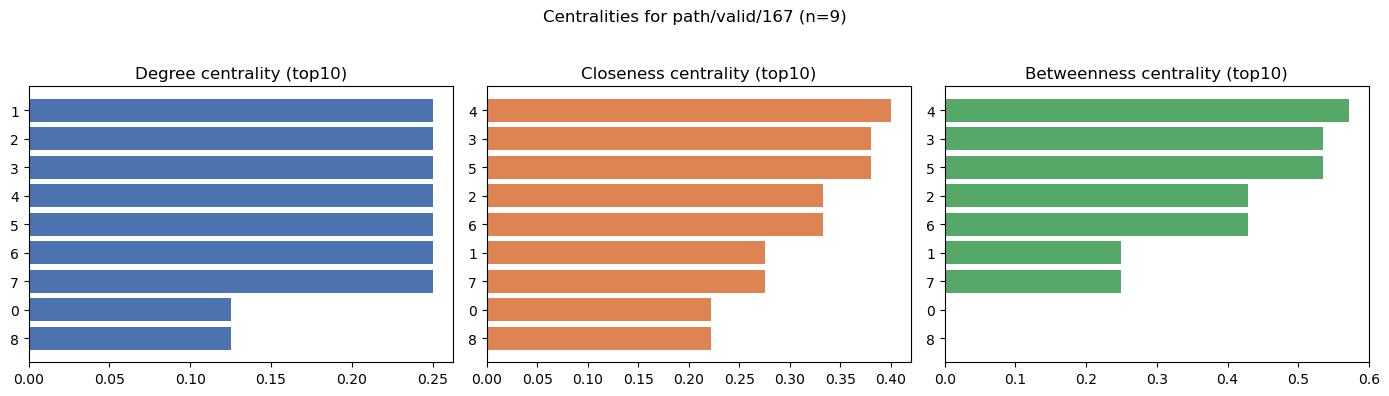

Saved viz/centrality_167.png


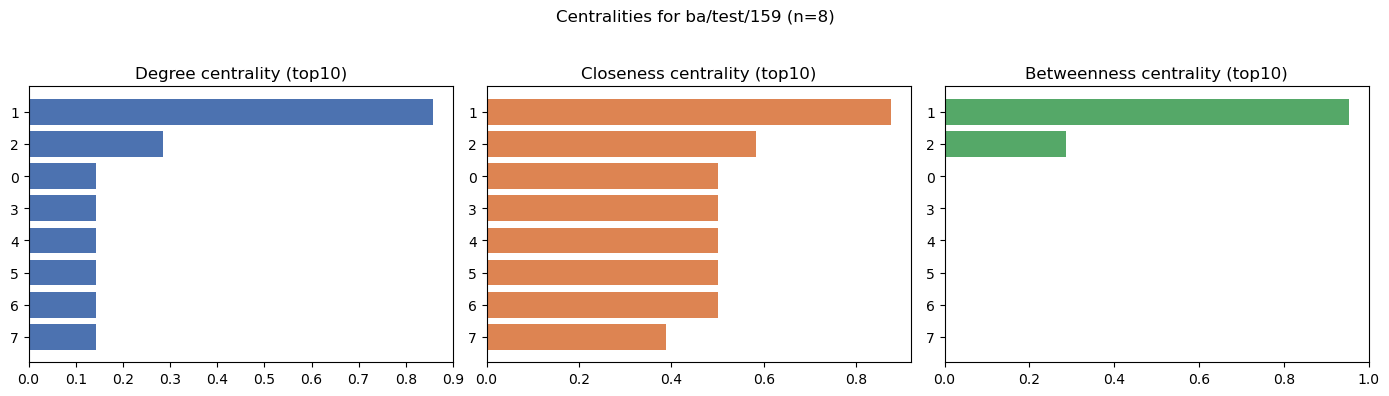

Saved viz/centrality_159.png


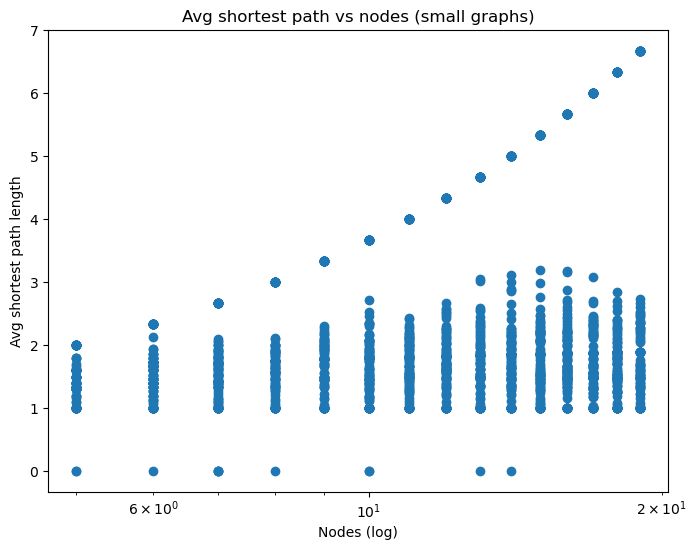

Saved viz/avg_shortest_path.png
Saved summary CSV to viz/graph_summary.csv


In [28]:
# Additional analyses: aggregated degree PDFs, component fractions, metric correlations, centralities, path metrics
from pathlib import Path
viz_out = Path('viz')
viz_out.mkdir(exist_ok=True)
good = df[good_mask].copy()
if good.empty:
    print('No good graphs to analyze.')
else:
    # Aggregated degree distributions per dataset (sample up to 50 graphs per dataset)
    plt.figure(figsize=(8,6))
    datasets = sorted(good['dataset'].unique())
    cmap = plt.get_cmap('tab20')
    for i,d in enumerate(datasets):
        sub = good[good['dataset'] == d]
        deg_values = []
        sample_files = sub['path'].tolist()[:50]
        for p in sample_files:
            try:
                G = nx.read_graphml(p)
                deg_values.extend([dd for _, dd in G.degree()])
            except Exception:
                continue
        if not deg_values:
            continue
        degs = np.array(deg_values)
        maxk = max(1, int(degs.max()))
        bins = np.logspace(0, math.log10(maxk + 1), num=50)
        hist, edges = np.histogram(degs, bins=bins)
        pdf = hist / hist.sum() if hist.sum() > 0 else hist
        centers = (edges[:-1] + edges[1:]) / 2.0
        plt.step(centers, pdf + 1e-12, where='mid', label=d, color=cmap(i % 20))
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree (log)')
    plt.ylabel('PDF')
    plt.title('Aggregated degree distribution by dataset (sampled graphs)')
    plt.legend(fontsize='small')
    plt.tight_layout()
    out = viz_out / 'degree_dist_by_dataset.png'
    plt.savefig(out, dpi=150)
    plt.show()
    print('Saved', out)

    # Component size distribution: largest_cc fraction per dataset
    plt.figure(figsize=(10,6))
    groups = [ (good.loc[good['dataset']==d,'largest_cc'] / good.loc[good['dataset']==d,'nodes']).dropna().values for d in datasets ]
    # filter empty groups
    groups_filtered = [g for g in groups if len(g) > 0]
    labels = [d for d,g in zip(datasets,groups) if len(g) > 0]
    if groups_filtered:
        plt.boxplot(groups_filtered, labels=labels, showfliers=False, patch_artist=True)
        plt.xticks(rotation=45)
        plt.ylabel('Largest CC fraction')
        plt.title('Largest connected component fraction by dataset')
        plt.tight_layout()
        out = viz_out / 'largest_cc_fraction.png'
        plt.savefig(out, dpi=150)
        plt.show()
        print('Saved', out)
    else:
        print('No component size data available.')

    # Correlation matrix of numeric metrics
    num_cols = ['nodes','edges','avg_deg','deg_median','deg_std','density','edges_per_node','largest_cc','avg_cc_size']
    num = good[num_cols].dropna() if all(c in good.columns for c in num_cols) else good.select_dtypes(include=[np.number]).dropna()
    if not num.empty:
        corr = num.corr()
        plt.figure(figsize=(8,6))
        im = plt.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ticks = range(len(corr.columns))
        plt.xticks(ticks, corr.columns, rotation=45, ha='right')
        plt.yticks(ticks, corr.columns)
        for (i,j), val in np.ndenumerate(corr.values):
            plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=8)
        plt.title('Correlation matrix of graph metrics (sample)')
        plt.tight_layout()
        out = viz_out / 'metric_correlation.png'
        plt.savefig(out, dpi=150)
        plt.show()
        print('Saved', out)
    else:
        print('Not enough numeric data for correlations.')

    # Centrality summaries for up to 3 small graphs
    small = good[good['nodes'] <= 200].copy() if 'nodes' in good.columns else good.copy()
    if small.empty:
        print('No small graphs for centrality computation.')
    else:
        sample = small.sample(n=min(3, len(small)), random_state=42)
        for _, row in sample.iterrows():
            p = Path(row['path'])
            try:
                G = nx.read_graphml(p)
            except Exception as e:
                print('Failed to read', p, e); continue
            # operate on largest connected component
            try:
                if nx.is_directed(G):
                    comp_nodes = max(nx.weakly_connected_components(G), key=len)
                else:
                    comp_nodes = max(nx.connected_components(G), key=len)
                Gc = G.subgraph(comp_nodes).copy()
            except Exception:
                Gc = G
            deg_cent = nx.degree_centrality(Gc)
            clos = nx.closeness_centrality(Gc)
            try:
                bet = nx.betweenness_centrality(Gc, k=min(50, Gc.number_of_nodes()), seed=42) if Gc.number_of_nodes() > 100 else nx.betweenness_centrality(Gc)
            except Exception:
                bet = {n: 0.0 for n in Gc.nodes()}
            def topk(d, k=10):
                items = sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]
                if not items:
                    return ([], [])
                keys, vals = zip(*items)
                return keys, vals
            names_deg, vals_deg = topk(deg_cent, 10)
            names_clo, vals_clo = topk(clos, 10)
            names_bet, vals_bet = topk(bet, 10)
            fig, axes = plt.subplots(1, 3, figsize=(14, 4))
            if vals_deg:
                axes[0].barh(range(len(vals_deg)), list(vals_deg)[::-1], color='#4c72b0')
                axes[0].set_yticks(range(len(vals_deg))); axes[0].set_yticklabels(list(names_deg)[::-1])
            axes[0].set_title('Degree centrality (top10)')
            if vals_clo:
                axes[1].barh(range(len(vals_clo)), list(vals_clo)[::-1], color='#dd8452')
                axes[1].set_yticks(range(len(vals_clo))); axes[1].set_yticklabels(list(names_clo)[::-1])
            axes[1].set_title('Closeness centrality (top10)')
            if vals_bet:
                axes[2].barh(range(len(vals_bet)), list(vals_bet)[::-1], color='#55a868')
                axes[2].set_yticks(range(len(vals_bet))); axes[2].set_yticklabels(list(names_bet)[::-1])
            axes[2].set_title('Betweenness centrality (top10)')
            plt.suptitle(f"Centralities for {row.get('dataset','?')}/{row.get('split','')}/{p.stem} (n={row.get('nodes','?')})")
            plt.tight_layout(rect=[0,0,1,0.95])
            out = viz_out / f"centrality_{p.stem}.png"
            plt.savefig(out, dpi=150)
            plt.show()
            print('Saved', out)

    # Average shortest path and diameter for sampled small graphs
    paths = []
    for _, row in small.iterrows():
        p = Path(row['path'])
        try:
            G = nx.read_graphml(p)
        except Exception:
            continue
        try:
            if nx.is_directed(G):
                comps = list(nx.weakly_connected_components(G))
            else:
                comps = list(nx.connected_components(G))
            largest = max(comps, key=len)
            H = G.subgraph(largest).copy()
            if H.number_of_nodes() > 1:
                asp = nx.average_shortest_path_length(H)
                diam = nx.diameter(H) if H.number_of_nodes() <= 1000 else None
            else:
                asp = 0; diam = 0
            paths.append({'path': str(p), 'nodes': G.number_of_nodes(), 'avg_shortest_path': asp, 'diameter': diam})
        except Exception:
            continue
    if paths:
        paths_df = pd.DataFrame(paths)
        plt.figure(figsize=(8,6))
        plt.scatter(paths_df['nodes'], paths_df['avg_shortest_path'])
        plt.xscale('log'); plt.xlabel('Nodes (log)')
        plt.ylabel('Avg shortest path length')
        plt.title('Avg shortest path vs nodes (small graphs)')
        out = viz_out / 'avg_shortest_path.png'
        plt.savefig(out, dpi=150)
        plt.show()
        print('Saved', out)
    else:
        print('No path metrics computed.')

    # Save summary CSV
    out_csv = viz_out / 'graph_summary.csv'
    df.to_csv(out_csv, index=False)
    print('Saved summary CSV to', out_csv)

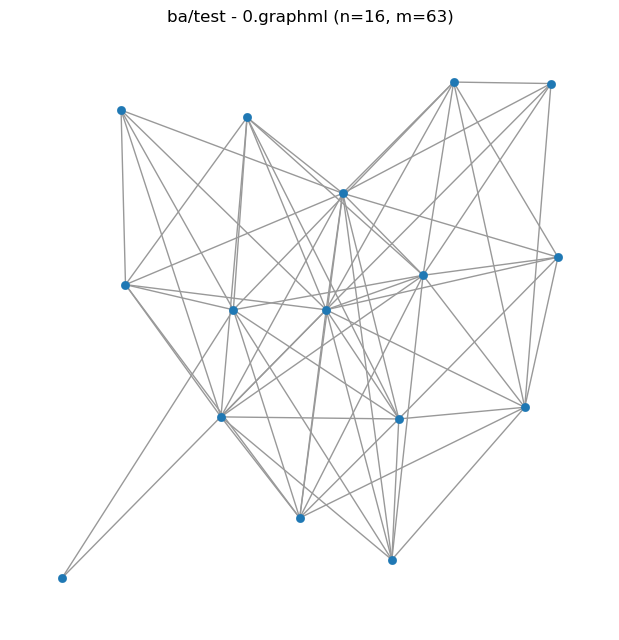

Saved viz/ba_test_0.png


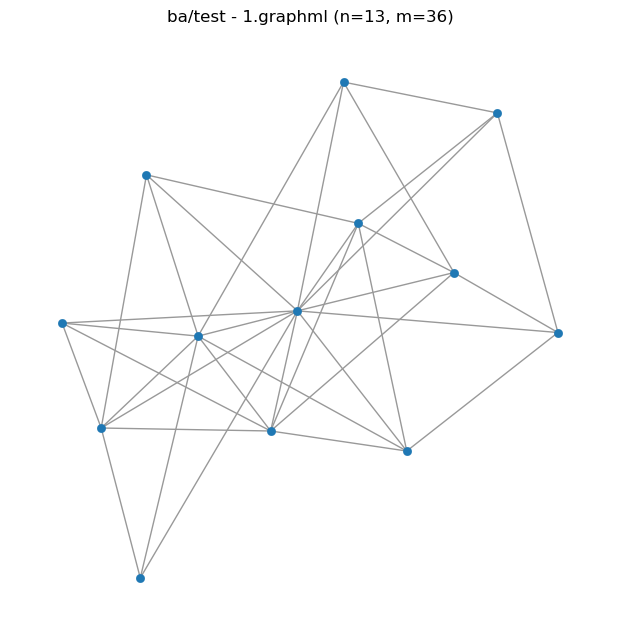

Saved viz/ba_test_1.png


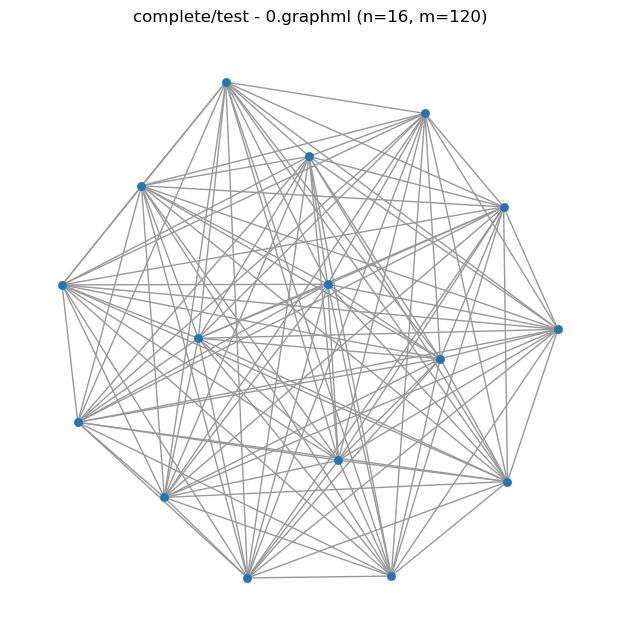

Saved viz/complete_test_0.png


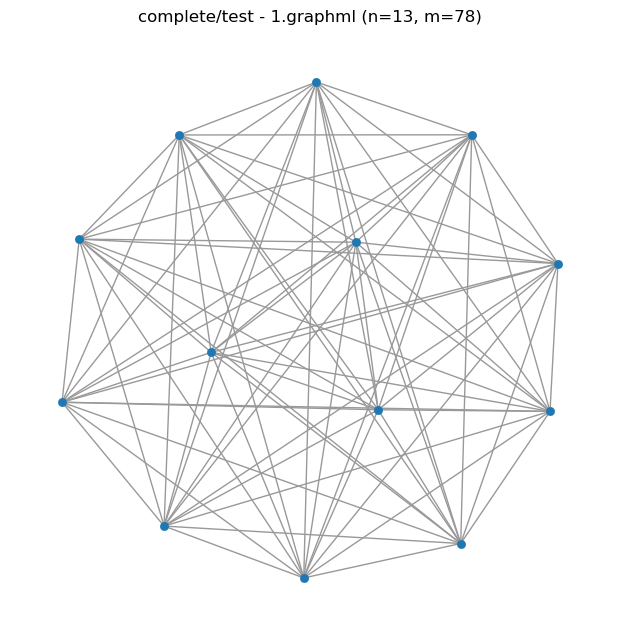

Saved viz/complete_test_1.png


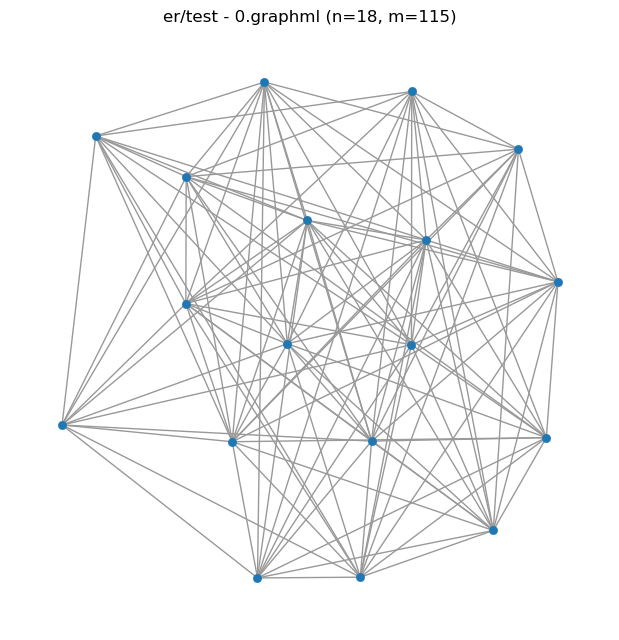

Saved viz/er_test_0.png


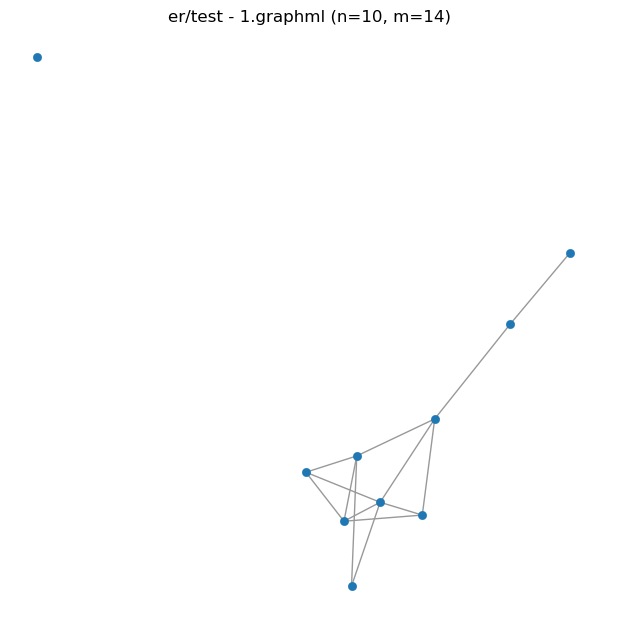

Saved viz/er_test_1.png


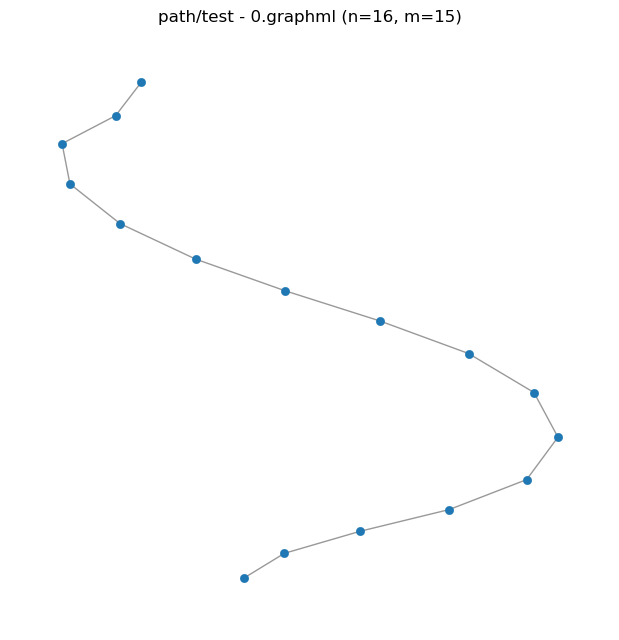

Saved viz/path_test_0.png


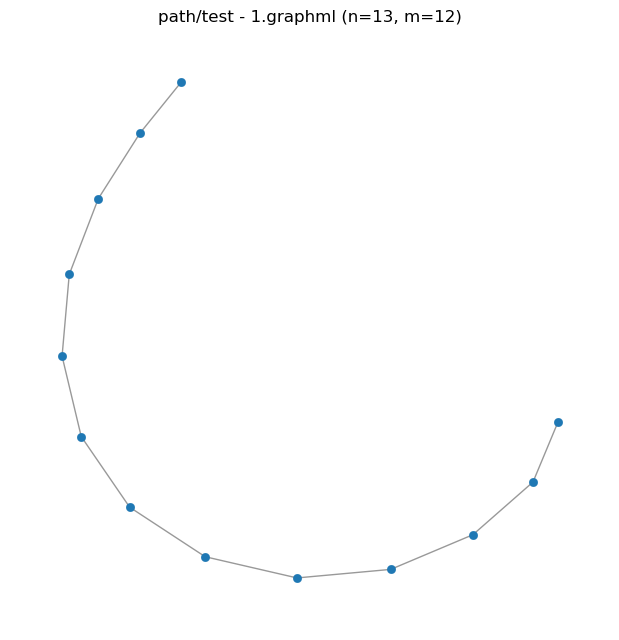

Saved viz/path_test_1.png


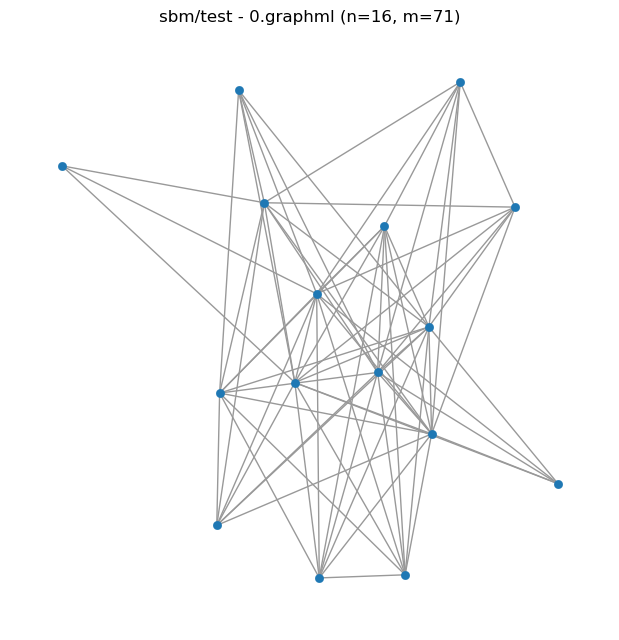

Saved viz/sbm_test_0.png


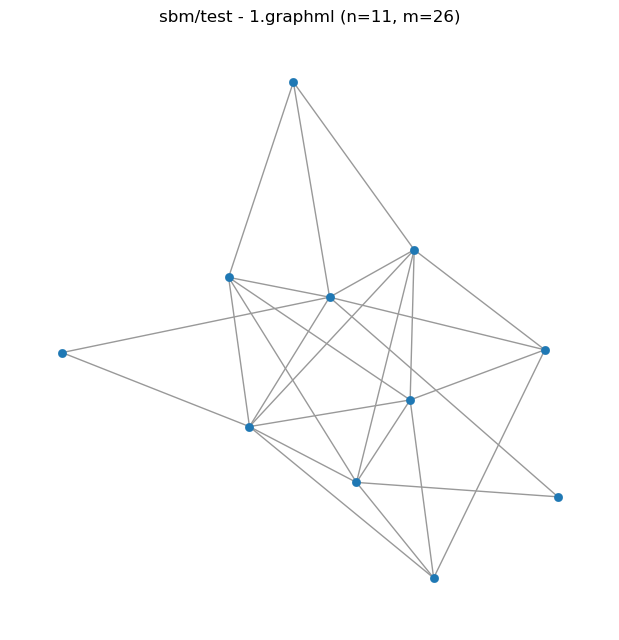

Saved viz/sbm_test_1.png


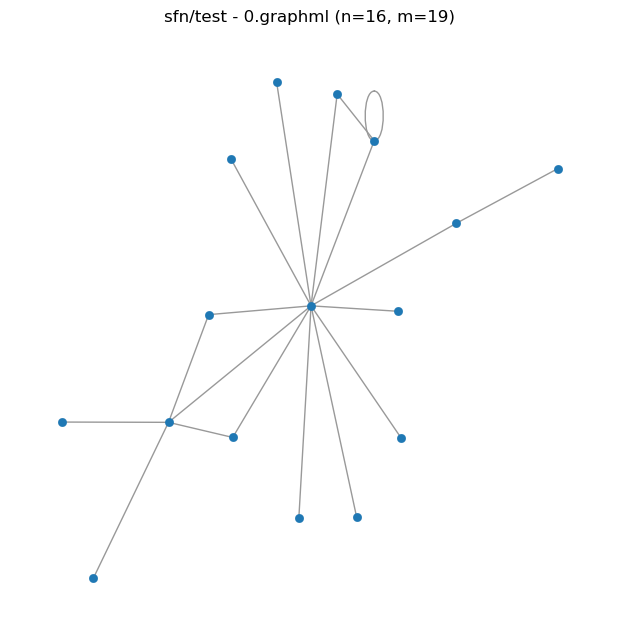

Saved viz/sfn_test_0.png


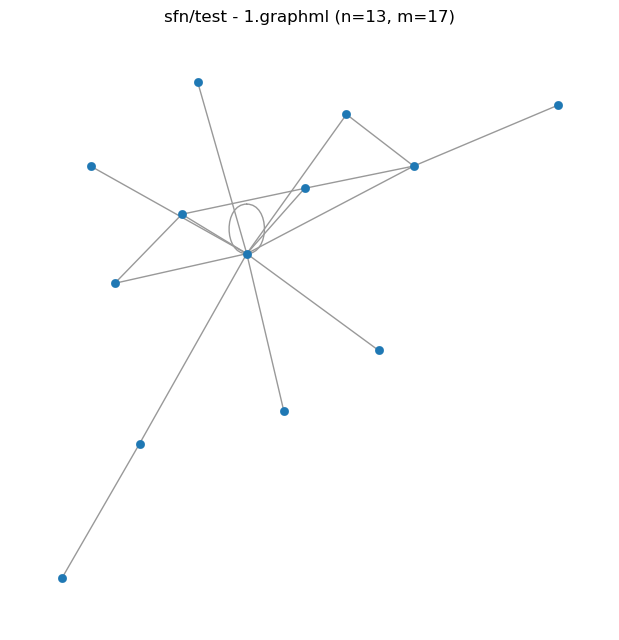

Saved viz/sfn_test_1.png


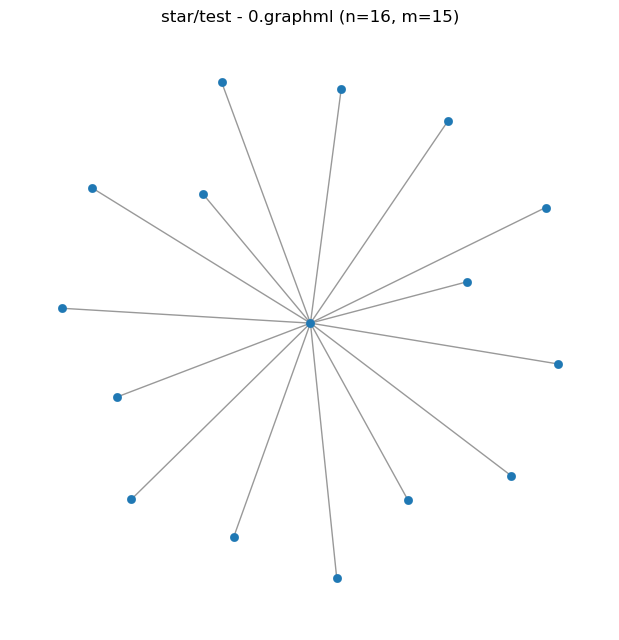

Saved viz/star_test_0.png


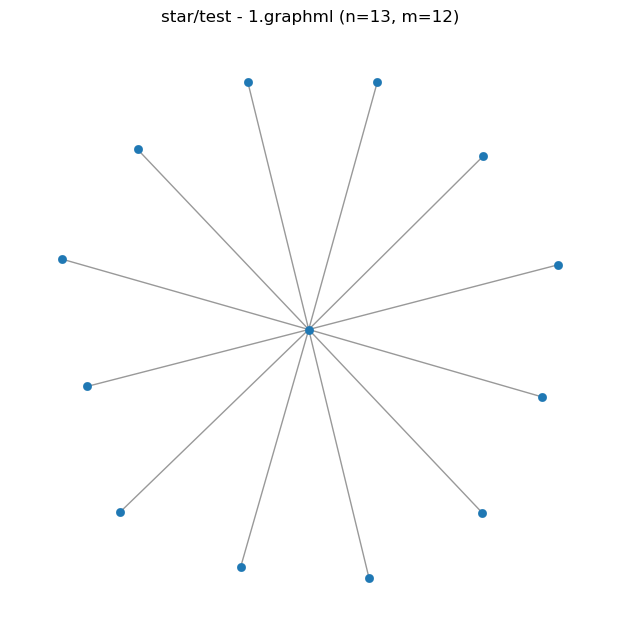

Saved viz/star_test_1.png


In [29]:
# Visualize a few small graphs using networkx (up to 2 per dataset).
from pathlib import Path
viz_out = Path('viz')
viz_out.mkdir(exist_ok=True)
# use the safe good_mask computed earlier (falls back to path-only if no 'error' column)
if 'error' in df.columns:
    good_mask = df['path'].notnull() & df['error'].isna()
else:
    good_mask = df['path'].notnull()
small = df[good_mask & (df['nodes'] <= 80)] if 'nodes' in df.columns else df[good_mask].head(10)
if small.empty:
    print('No small graphs found (nodes <= 80). Increase threshold or ensure nodes were computed.')
else:
    for ds, group in small.groupby('dataset'):
        for _, row in group.head(2).iterrows():
            p = Path(row['path'])
            try:
                G = nx.read_graphml(p)
            except Exception as e:
                print('Failed to read', p, e)
                continue
            # choose a layout - spring for general graphs
            plt.figure(figsize=(6,6))
            try:
                pos = nx.spring_layout(G, seed=42)
            except Exception:
                pos = None
            nx.draw(G, pos=pos, node_size=40, linewidths=0.1, edge_color='#999999', node_color='#1f78b4', with_labels=False)
            title = f"{ds}/{row.get('split','?')} - {p.name} (n={row.get('nodes','?')}, m={row.get('edges','?')})"
            plt.title(title)
            out = viz_out / f"{ds}_{row.get('split','')}_{p.stem}.png"
            plt.savefig(out, dpi=150, bbox_inches='tight')
            plt.show()
            print('Saved', out)

/data/young/miniconda3/envs/autograph/lib/python3.12/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
/tmp/ipykernel_987034/538994425.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups_f, labels=labels, showfliers=False, patch_artist=True)


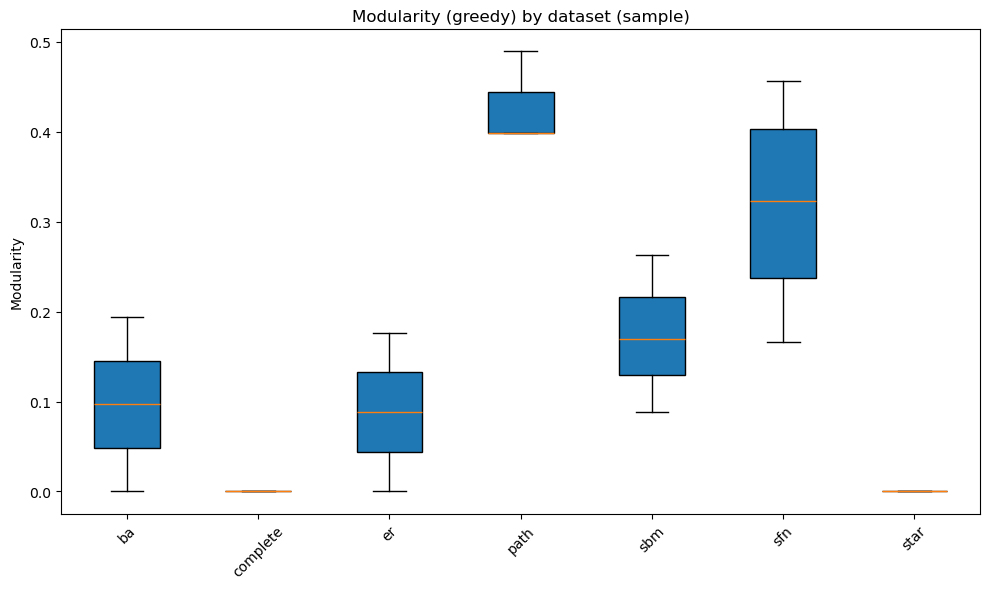

Saved viz/community_modularity_by_dataset.png


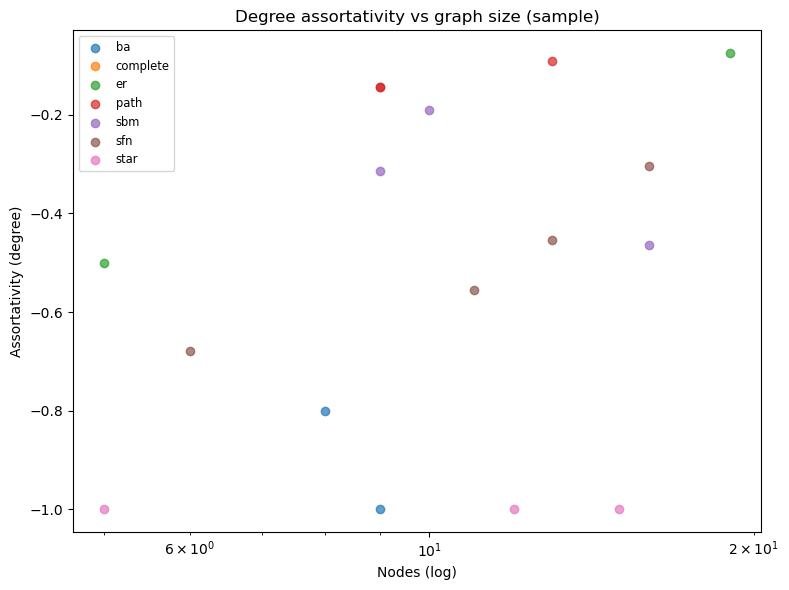

Saved viz/assortativity_vs_nodes.png


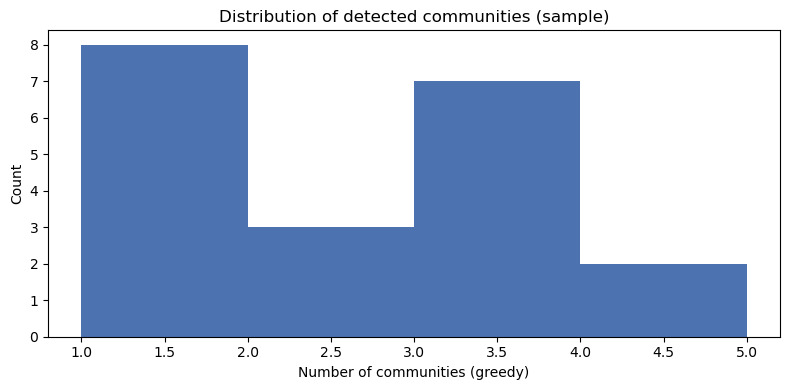

Saved viz/num_communities_hist.png
Saved community metrics to viz/community_metrics.csv


In [30]:
# Community detection, assortativity, and spectral-gap analysis for sampled small graphs
from pathlib import Path
viz_out = Path('viz')
viz_out.mkdir(exist_ok=True)
good = df[good_mask].copy()
small = good[good['nodes'] <= 400] if 'nodes' in good.columns else good
if small.empty:
    print('No small graphs for community/spectral analysis.')
else:
    sample = small.sample(n=min(20, len(small)), random_state=42) if len(small) > 20 else small
    rows = []
    for _, row in sample.iterrows():
        p = Path(row['path'])
        try:
            G = nx.read_graphml(p)
        except Exception as e:
            print('Failed to read', p, e); continue
        # work on largest (weak) connected component and undirected for community/spectral
        try:
            if nx.is_directed(G):
                comps = list(nx.weakly_connected_components(G))
            else:
                comps = list(nx.connected_components(G))
            largest = max(comps, key=len)
            Gc = G.subgraph(largest).copy()
            if nx.is_directed(Gc):
                Gc = Gc.to_undirected()
        except Exception:
            Gc = G if not nx.is_directed(G) else G.to_undirected()
        nodes = Gc.number_of_nodes()
        num_comms = None; modularity = None
        try:
            comms = list(nx.algorithms.community.greedy_modularity_communities(Gc))
            num_comms = len(comms)
            modularity = nx.algorithms.community.quality.modularity(Gc, comms) if num_comms > 0 else None
        except Exception:
            num_comms = None; modularity = None
        try:
            assort = nx.degree_assortativity_coefficient(G)
        except Exception:
            assort = None
        try:
            trans = nx.transitivity(G)
        except Exception:
            trans = None
        spectral_gap = None
        if nodes > 1 and nodes <= 400:
            try:
                A = nx.to_numpy_array(Gc)
                vals = np.linalg.eigvals(A)
                vals = np.sort(np.real(vals))[::-1]
                if len(vals) >= 2:
                    spectral_gap = float(vals[0] - vals[1])
                else:
                    spectral_gap = float(vals[0])
            except Exception:
                spectral_gap = None
        rows.append({'path': str(p), 'dataset': row.get('dataset'), 'nodes': int(row.get('nodes', nodes)), 'num_comms': num_comms, 'modularity': modularity, 'assortativity': assort, 'transitivity': trans, 'spectral_gap': spectral_gap})
    cm_df = pd.DataFrame(rows)
    if cm_df.empty:
        print('No community/spectral metrics computed.')
    else:
        # Boxplot of modularity by dataset
        plt.figure(figsize=(10,6))
        datasets = sorted(cm_df['dataset'].dropna().unique())
        groups = [cm_df.loc[cm_df['dataset'] == d, 'modularity'].dropna().values for d in datasets]
        groups_f = [g for g in groups if len(g) > 0]
        labels = [d for d,g in zip(datasets, groups) if len(g) > 0]
        if groups_f:
            plt.boxplot(groups_f, labels=labels, showfliers=False, patch_artist=True)
            plt.xticks(rotation=45)
            plt.ylabel('Modularity')
            plt.title('Modularity (greedy) by dataset (sample)')
            plt.tight_layout()
            out = viz_out / 'community_modularity_by_dataset.png'
            plt.savefig(out, dpi=150)
            plt.show()
            print('Saved', out)
        else:
            print('No modularity values to plot.')
        # Scatter: assortativity vs avg_deg
        if 'assortativity' in cm_df.columns and 'dataset' in cm_df.columns:
            plt.figure(figsize=(8,6))
            for i,d in enumerate(sorted(cm_df['dataset'].dropna().unique())):
                sub = cm_df[cm_df['dataset'] == d]
                plt.scatter(sub['nodes'], sub['assortativity'], label=d, alpha=0.7)
            plt.xscale('log')
            plt.xlabel('Nodes (log)')
            plt.ylabel('Assortativity (degree)')
            plt.title('Degree assortativity vs graph size (sample)')
            plt.legend(fontsize='small')
            plt.tight_layout()
            out = viz_out / 'assortativity_vs_nodes.png'
            plt.savefig(out, dpi=150)
            plt.show()
            print('Saved', out)
        # Histogram of number of communities
        if 'num_comms' in cm_df.columns and cm_df['num_comms'].notnull().any():
            plt.figure(figsize=(8,4))
            plt.hist(cm_df['num_comms'].dropna(), bins=range(1, int(cm_df['num_comms'].max())+2), color='#4c72b0')
            plt.xlabel('Number of communities (greedy)')
            plt.ylabel('Count')
            plt.title('Distribution of detected communities (sample)')
            out = viz_out / 'num_communities_hist.png'
            plt.tight_layout()
            plt.savefig(out, dpi=150)
            plt.show()
            print('Saved', out)
        # Save community metrics CSV
        out_cm = viz_out / 'community_metrics.csv'
        cm_df.to_csv(out_cm, index=False)
        print('Saved community metrics to', out_cm)

**Next steps / tips**
- Run the notebook to produce the summary and plots.
- To expand the analysis, increase `limit_per_split` or compute degree distributions per-graph.
- If you want me to run this analysis now and save outputs (figures / CSV), tell me and I will execute the notebook and return results.